In [10]:
import sys
sys.path.insert(0,'../')
from libs.ssl_dataloader import *
from libs.ssl_model import *
from libs.ssl_utils import *
from libs.eeg_utils import *
from braindecode.preprocessing import (
    preprocess, Preprocessor, create_fixed_length_windows)
from braindecode.datasets import BaseConcatDataset
from braindecode.datautil import load_concat_dataset
%load_ext autoreload
%autoreload 2
from torch import nn, optim
from torch.utils.data import DataLoader

## TOC:
* [Raw data](#first-bullet)
* [Preprocess data](#second-bullet)
* [Segment data window](#third-bullet)
    * [Load segmented window](#fourth-bullet)

## Raw data <a class="anchor" id="first-bullet"></a>

In [5]:
datasets = []
releases = list(range(9,0,-1))
hbn_datasets = ['ds005514','ds005512','ds005511','ds005510','ds005509','ds005508','ds005507','ds005506','ds005505']
hbn_release_ds = dict(zip(releases,hbn_datasets))

In [ ]:
# ds1 = HBNDataset(hbn_release_ds[1], tasks=['RestingState'], num_workers=-1, preload=False, data_path=f'data/{hbn_release_ds[1]}')
# ds2 = HBNDataset(hbn_release_ds[6], tasks=['RestingState'], num_workers=-1, preload=False, data_path=f'data/{hbn_release_ds[6]}')
if not os.path.exists('data'):
    os.makedirs('data', exist_ok=True)
if not os.path.exists('data/ds005510'):
    # download zip file from google drive and put it in data folder
    # https://drive.google.com/file/d/1KWEDoZOqyLojq0hQx8lUNTWSdZ5tBlTc/view?usp=sharing
    import zipfile
    with zipfile.ZipFile('data/ds005510.zip', 'r') as zip_ref:
        zip_ref.extractall('data')
# make sure you downloaded ds005505 and placed it in data folder
ds2 = HBNDataset(hbn_release_ds[6], tasks=['RestingState'], num_workers=-1, preload=False, data_path=f'data/{hbn_release_ds[6]}')

In [7]:
all_ds = BaseConcatDataset([ds2]) # [ds1, ds2]
all_ds.description

,task,session,run,subject,sfreq,age,sex,ehq_total,p_factor,attention,internalizing,externalizing
0,RestingState,,,NDARUT651WFC,500,17.4851,F,100.05,1.520,0.161,0.459,0.836
1,RestingState,,,NDARTY549YDG,500,5.5486,F,-50.02,0.075,-0.646,0.324,-0.336
2,RestingState,,,NDARUC022JWT,500,16.4749,M,94.51,1.169,-1.014,-0.541,0.603
3,RestingState,,,NDARKN346XZH,500,8.4447,F,100.05,-1.401,0.225,0.214,-0.370
4,RestingState,,,NDARUK101YT3,500,11.2050,M,96.72,-1.266,-0.093,-1.056,-0.057
5,RestingState,,,NDARUD306BB0,500,12.9846,M,60.03,0.148,0.028,-0.699,0.017
6,RestingState,,,NDARUP067TM8,500,6.4986,M,100.05,-0.185,-0.183,-1.121,0.480
7,RestingState,,,NDARYW984FLT,500,8.0866,F,80.04,1.156,0.011,-1.025,0.009
8,RestingState,,,NDARAE877NER,500,11.3413,F,66.70,0.166,0.871,1.085,-0.931
9,RestingState,,,NDARUL454XRE,500,10.8901,M,-26.68,0.758,0.308,-0.555,-0.398


### Save to disk using braindecode

In [ ]:
os.makedirs('data/hbn', exist_ok=True)
all_ds.save('data/hbn', overwrite=True)

#### Load raw data from braindecode

In [47]:
loaded_dataset = load_concat_dataset(path='data/hbn', preload=False)
all_ds = loaded_dataset

### Visualize data sample

Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
sampling_freq: 500.0
(array([[-0.00721584, -0.00721364, -0.00721263, ..., -0.0093889 ,
        -0.0094284 , -0.00949214]]), array([ 10.   ,  10.002,  10.004, ..., 499.994, 499.996, 499.998]))
-0.011335335908881028 -0.00608983299243715


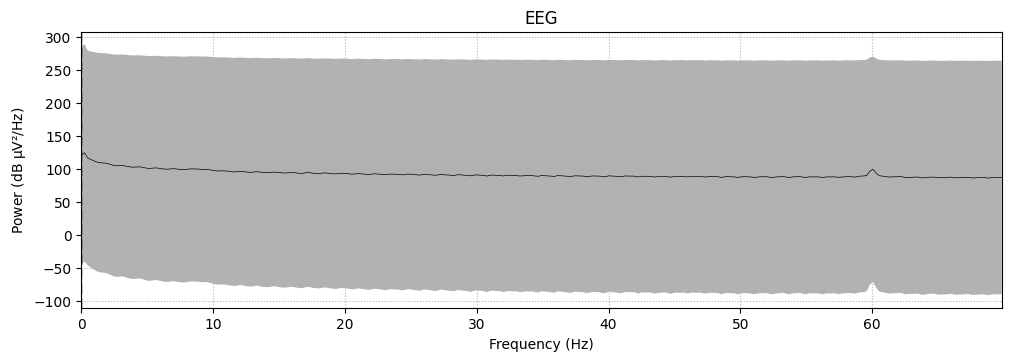

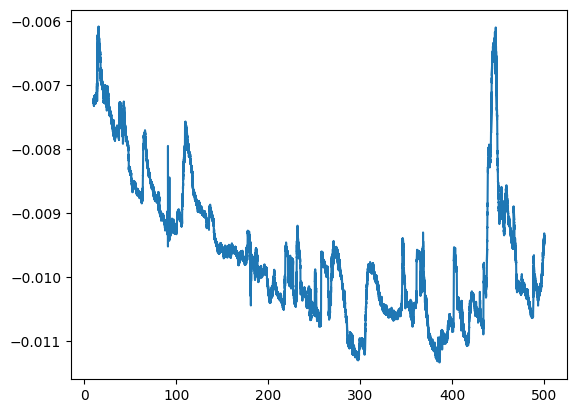

In [32]:
raw = all_ds.datasets[1].raw
fig = raw.compute_psd(fmax=70).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)
sampling_freq = raw.info["sfreq"]
print('sampling_freq:', sampling_freq)
start_stop_seconds = np.array([10, 500])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)
channel_index = 0
raw_selection = raw[channel_index, start_sample:stop_sample]
print(raw_selection)
x = raw_selection[1]
y = raw_selection[0].T
print(np.min(y),np.max(y))
plt.figure()
plt.plot(x, y)
plt.show()

## Preprocess data <a class="anchor" id="second-bullet"></a>

In [48]:
from sklearn.preprocessing import scale as standard_scale

os.makedirs('data/hbn_preprocessed', exist_ok=True)

sampling_rate = 250 # resample to follow the tutorial sampling rate
high_cut_hz = 59
# Factor to convert from V to uV
factor = 1e6
preprocessors = [
    Preprocessor(lambda data: np.multiply(data, factor)),  # Convert from V to uV
    Preprocessor('crop', tmin=10),  # crop first 10 seconds as begining of noise recording
    Preprocessor('filter', l_freq=None, h_freq=high_cut_hz),
    Preprocessor('resample', sfreq=sampling_rate),
    Preprocessor('notch_filter', freqs=(60, 120)),
    Preprocessor(standard_scale, channel_wise=True),
]

# Transform the data
preprocess(all_ds, preprocessors, save_dir='data/hbn_preprocessed', overwrite=True, n_jobs=-1)

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/preprocessing/preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


Reading 0 ... 175633  =      0.000 ...   351.266 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Reading 0 ... 197431  =      0.000 ...   394.862 secs...
Reading 0 ... 193507  =      0.000 ...   387.014 secs...
Reading 0 ... 195978  =      0.000 ...   391.956 secs...
Reading 0 ... 281415  =      0.000 ...   562.830 secs...
Reading 0 ... 213829  =      0.000 ...   427.658 secs...
Reading 0 ... 184005  =      0.000 ...   368.010 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Reading 0 ... 184057  =      0.000 ...   368.114 secs...
Reading 0 ... 196802  =      0.000 ...   393.604 secs...
Reading 0 ... 231476  =      0.000 ...   462.952 secs...
Reading 0 ... 173505  =      0.000 ...   347.010 secs...
Reading 0 ... 180506  =      0.000 ...   361.012 secs...
Reading 0 ... 173506  =      0.000 ...   347.012 secs...
Reading 0 ... 174355  =      0.000 ...   348.710 secs...
Reading 0 ... 243425  =      0.000 ...   486.850 secs...
Reading 0 ... 211028  =      0.000 ...   422.056 secs...
Reading 0 ... 289255  =      0.000 ...   578.510 secs...
Reading 0 ... 185782  =      0.000 ...   371.564 secs...
Reading 0 ... 328630  =      0.000 ...   657.260 secs...
Reading 0 ... 176732  =      0.000 ...   353.464 secs...
Reading 0 ... 175857  =      0.000 ...   351.714 secs...
Reading 0 ... 365019  =      0.000 ...   730.038 secs...
Reading 0 ... 214953  =      0.000 ...   429.906 secs...
Reading 0 ... 172457  =      0.000 ...   344.914 secs...
Reading 0 ... 202302  =      0.

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter par

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter par

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/6/6-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setting up low-p

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (7) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87', '

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz
Setting up low-pass filter at 59 Hz

FIR filter parameters

FIR filter parameters
---------------------
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Windowed time-domain design (firwin) method
- Hamming

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Reading 0 ... 246354  =      0.000 ...   492.708 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Do

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.4s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/5/5-raw.fif


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/7/7-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/5/5-raw.fif
[done]


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (6) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '2

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/4/4-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/7/7-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (8) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '2

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/4/4-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter param

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is pr

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and 

- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/13/13-raw.fif
[done]
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/25/25-raw.fif
[done]
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/16/16-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/24/24-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/28/28-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-ca

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (26) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87', 

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Reading 0 ... 183877  =      0.000 ...   367.754 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (25) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '112', '38', '198', '146',

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/21/21-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/24/24-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/12/12-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/26/26-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/3/3-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/28/28-raw.fif
[done]


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (29) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/21/21-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/27/27-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Reading 0 ... 179052  =      0.000 ...   358.104 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
Reading 0 ... 177057  =      0.000 ...   354.114 secs...
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper p

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (27) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/9/9-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/20/20-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/0/0-raw.fif
Reading 0 ... 306681  =      0.000 ...   613.362 secs...
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/2/2-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain des

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (10) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/9/9-raw.fif
[done]
Reading 0 ... 221302  =      0.000 ...   442.604 secs...
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/19/19-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/0/0-raw.fif
[done]
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/20/20-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/11/11-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/2/2-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/30/30-raw.fif
Reading 0 ... 173108  =      0.000 ...   346.216 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (3) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87', '

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/8/8-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/18/18-raw.fif
Reading 0 ... 181209  =      0.000 ...   362.418 secs...
Reading 0 ... 190827  =      0.000 ...   381.654 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/11/11-raw.fif
[done]
Reading 0 ... 177155  =      0.000 ...   354.310 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/19/19-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/29/29-raw.fif

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (12) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87', 

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/30/30-raw.fif
Reading 0 ... 191804  =      0.000 ...   383.608 secs...
[done]
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/8/8-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (30) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The nu

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/29/29-raw.fif
[done]
Reading 0 ... 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s


Reading 0 ... 188779  =      0.000 ...   377.558 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Reading 0 ... 285714  =      0.000 ..

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (16) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '13

Reading 0 ... 214078  =      0.000 ...   428.156 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Reading 0 ... 189355  =      0.000 ..

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (33) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87', 

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter par

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Reading 0 ... 195977  =      0.000 ...   391.954 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter par

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.5s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard devia

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a on

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (35) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', 

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/34/34-raw.fif
[done]
Reading 0 ... 205428  =      0.000 ...   410.856 secs...


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
Filtering raw data in 1 contiguous segment
- Filter length: 1651 samples (6.604 s)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.2s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
Filtering raw data in 1 contiguous segment
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/37/37-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocesse

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/36/36-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/37/37-raw.fif
[done]
Reading 0 ... 221631  =      0.000 ...   443.262 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (38) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87', 

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/38/38-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/42/42-raw.fif
Reading 0 ... 173432  =      0.000 ...   346.864 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/36/36-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband atten

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (34) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87', '106',

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/45/45-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/43/43-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/42/42-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition ba

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (43) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87', 

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/45/45-raw.fif
[done]
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/43/43-raw.fif
[done]
Reading 0 ... 190452  =      0.000 ...   380.904 secs...
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/35/35-raw.fif
Reading 0 ... 305855  =      0.000 ...   611.710 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/41/41-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/39/39-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/35/35-raw.fif
[done]
Reading 0 ... 198378  =      0.000 ...   396.756 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (40) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '13

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/41/41-raw.fif
[done]
Reading 0 ... 175259  =      0.000 ...   350.518 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (42) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '13

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Reading 0 ... 173635  =      0.000 ...   347.270 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and 

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/47/47-raw.fif
[done]
Reading 0 ... 174858  =      0.000 ...   349.716 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.6

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (24) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/23/23-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_prep

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/44/44-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/48/48-raw.fif
[done]
Reading 0 ... 173357  =      0.000 ...   346.714 secs...
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/46/46-raw.fif


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (45) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/44/44-raw.fif
[done]
Reading 0 ... 503570  =      0.000 ...  1007.140 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/46/46-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Reading 0 ... 425172  =      0.000 ...   850.344 secs...
Reading 0 ... 171807  =      0.000 ...   343.614 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/49/49-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up low

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/54/54-raw.fif
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (50) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/49/49-raw.fif
[done]
Reading 0 ... 177409  =      0.000 ...   354.818 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/54/54-raw.fif
[done]
Reading 0 ... 186602  =      0.000 ...   373.204 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (55) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', 

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/59/59-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/17/17-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/59/59-raw.fif
[done]
Reading 0 ... 212878  =      0.000 ...   425.756 secs...
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/52/52-raw.fif
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed ti

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (60) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '153', '84', '182', '239', '58', '76', '13', '87', '106',

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/51/51-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/17/17-raw.fif
[done]


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (18) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87', 

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/52/52-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/56/56-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/60/60-raw.fif
Reading 0 ... 176307  =      0.000 ...   352.614 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/51/51-raw.fif
[done]
Reading 0 ... 219304  =      0.000 ...   438.608 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/60/60-raw.fif
[done]
Reading 0 ... 200980  =      0.000 ...   401.960 secs...
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/57/57-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (61) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87', 

Reading 0 ... 192754  =      0.000 ...   385.508 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/57/57-raw.fif
[done]
Reading 0 ... 278053  =      0.000 ...   556.106 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (58) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '5

Reading 0 ... 206901  =      0.000 ...   413.802 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/31/31-raw.fif


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (62) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The nu

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/61/61-raw.fif
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up ban

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (66) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33'

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/65/65-raw.fif
[done]
Reading 0 ... 183305  =      0.000 ...   366.610 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/31/31-raw.fif
[done]


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.2s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Design

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/63/63-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocesse

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (65) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '5

Reading 0 ... 232677  =      0.000 ...   465.354 secs...
Reading 0 ... 258073  =      0.000 ...   516.146 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/63/63-raw.fif
[done]
Reading 0 ... 173058  =      0.000 ...   346.116 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
Filtering raw data in 1 contiguous segment
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
Setting up low-pass filter at 59 Hz
- Upper passband edge: 59.00 Hz

- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (70) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87', '106',

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/62/62-raw.fif


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/73/73-raw.fif
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/62/62-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff fr

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (63) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '5

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/73/73-raw.fif
[done]
Reading 0 ... 252202  =      0.000 ...   504.404 secs...
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/74/74-raw.fif


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (73) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/72/72-raw.fif
[done]
Reading 0 ... 175457  =      0.000 ...   350.914 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/1/1-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/70/70-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/74/74-raw.fif
[done]
Reading 0 ... 352208  =      0.000 ...   704.416 secs...


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (75) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '13

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/70/70-raw.fif
[done]
Reading 0 ... 239016  =      0.000 ...   478.032 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/71/71-raw.fif


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (72) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '13

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/71/71-raw.fif
[done]
Reading 0 ... 200677  =      0.000 ...   401.354 secs...
Reading 0 ... 175708  =      0.000 ...   351.416 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/77/77-raw.fif


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (78) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '1

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/77/77-raw.fif
[done]
Reading 0 ... 199052  =      0.000 ...   398.104 secs...


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a on

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-caus

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and 

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/78/78-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter pa

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_dat

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/78/78-raw.fif
[done]
Reading 0 ... 295525  =      0.000 ...   591.050 secs...
Filtering raw data in 1 conti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/86/86-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/79/79-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/83/83-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/89/89-raw.fif


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/79/79-raw.fif
[done]
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/83/83-raw.fif
[done]
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/89/89-raw.fif
[done]
Reading 0 ... 205378  =      0.000 ...   410.756 secs...
Reading 0 ... 184780  =      0.000 ...   369.560 secs...
Reading 0 ... 222605  =      0.000 ...   445.210 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/86/86-raw.fif
[done]


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (80) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87', '106',

Reading 0 ... 204528  =      0.000 ...   409.056 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/87/87-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/84/84-raw.fif


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.6s


Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/82/82-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/87/87-raw.fif
[done]
Reading 0 ... 196527  =      0.000 ...   393.054 secs...
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/80/80-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/81/81-raw.fif


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (88) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '106',

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/82/82-raw.fif
[done]
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/84/84-raw.fif
[done]
Reading 0 ... 264598  =      0.000 ...   529.196 secs...
Reading 0 ... 172356  =      0.000 ...   344.712 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/81/81-raw.fif
[done]
Reading 0 ... 195003  =      0.000 ...   390.006 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (83) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87', '106',

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/80/80-raw.fif
[done]
Reading 0 ... 171633  =      0.000 ...   343.266 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
Filtering raw data in 1 contiguous segment
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a on

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s


Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/95/95-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/40/40-raw.fif


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s


Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/95/95-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/88/88-raw.fif
Reading 0 ... 297010  =      0.000 ...   594.020 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (96) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87', 

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/88/88-raw.fif
[done]
Reading 0 ... 181081  =      0.000 ...   362.162 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/40/40-raw.fif
[done]
Reading 0 ... 177733  =      0.000 ...   355.466 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (89) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', 

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/92/92-raw.fif
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
Filtering raw data in 1 contiguous segment
- Filter length: 113 samples (0.226 s)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/92/92-raw.fif
[done]
Reading 0 ... 180608  =      0.000 ...   361.216 s

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (93) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87', 

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/90/90-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/93/93-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/101/101-raw.fif


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s


Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/90/90-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/97/97-raw.fif
Reading 0 ... 175757  =      0.000 ...   351.514 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/93/93-raw.fif
[done]
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/101/101-raw.fif
[done]
Reading 0 ... 197380  =      0.000 ...   394.760 secs...
Reading 0 ... 503208  =      0.000 ...  1006.416 secs...


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (91) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '13

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/97/97-raw.fif
[done]
Reading 0 ... 174582  =      0.000 ...   349.164 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (98) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87', 

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/100/100-raw.fif
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/100/100-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/91/91-raw.fif
[done]
Reading 0 ... 194027  =      0.000 ...   388.054 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (101) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87', '106',

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/91/91-raw.fif
[done]
Reading 0 ... 174333  =      0.000 ...   348.666 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 conti

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (92) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87', 

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/53/53-raw.fif
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/53/53-raw.fif
[done]
Reading 0 ... 191552  =      0.000 ...   383.104 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (54) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '13

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/102/102-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/107/107-raw.fif
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequ

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/107/107-raw.fif
[done]
Reading 0 ... 206502  =      0.000 ...   413.004 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/102/102-raw.fif
[done]


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (108) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '1

Reading 0 ... 173181  =      0.000 ...   346.362 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/58/58-raw.fif


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.3s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/99/99-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/58/58-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/96/96-raw.fif
Reading 0 ... 217504  =      0.000 ...   435.008 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (59) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '76', '13', '87', '106',

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/99/99-raw.fif
Filtering raw data in 1 contiguous segment
[done]
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter par

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (100) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87',

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/106/106-raw.fif
[done]
Reading 0 ..

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (107) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87',

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Design

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/111/111-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/108/108-raw.fif


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (109) does not match the number of existing subdirectories (270). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '8

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/108/108-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/104/104-raw.fif
Reading 0 ... 180232  =      0.000 ...   360.464 secs...
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/115/115-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/111/111-raw.fif
[done]


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (112) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24

Reading 0 ... 205053  =      0.000 ...   410.106 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/109/109-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/104/104-raw.fif
[done]
Reading 0 ... 209956  =      0.000 ...   419.912 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/115/115-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamm

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (105) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87',

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/109/109-raw.fif
[done]
Reading 0 ... 173558  =      0.000 ...   347.116 secs...
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/68/68-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/105/105-raw.fif
[done]
Reading 0 ... 180982  =      0.000 ...   361.964 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/110/110-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Reading 0 ... 175903  =      0.000 ...   351.806 secs...
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/112/112-raw.fif


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (110) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87', '106',

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/112/112-raw.fif
[done]
Reading 0 ... 177202  =      0.000 ...   354.404 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/68/68-raw.fif
[done]
Reading 0 ... 179161  =      0.000 ...   358.322 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/120/120-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/121/121-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/120/120-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.3s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (121) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130',

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/121/121-raw.fif
[done]
Reading 0 ... 186552  =      0.000 ...   373.104 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filt

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/117/117-raw.fif
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (118) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198',

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/117/117-raw.fif
[done]
Reading 0 ... 235802  =      0.000 ...   471.604 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/116/116-raw.fif
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/118/118-raw.fif


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.3s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (86) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/122/122-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/85/85-raw.fif
[done]
Reading 0 ... 176303  =      0.000 ...   352.606 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/116/116-raw.fif
[done]
Reading 0 ... 177488  =      0.000 ...   354.976 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (117) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87',

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/122/122-raw.fif
[done]
Reading 0 ... 179153  =      0.000 ...   358.306 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/118/118-raw.fif
[done]
Reading 0 ... 177253  =      0.000 ...   354.506 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s


Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/114/114-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/126/126-raw.fif


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (115) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', 

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/114/114-raw.fif
[done]
Reading 0 ... 178727  =      0.000 ...   357.454 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (127) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87', '106',

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/125/125-raw.fif


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (126) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '8

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/125/125-raw.fif
[done]
Reading 0 ... 218933  =      0.000 ...   437.866 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/128/128-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/127/127-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (128) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '1

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.2s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/129/129-raw.fif


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/123/123-raw.fif
Writing /home/dung/

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (130) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87',

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/124/124-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/130/130-raw.fif
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Reading 0 ... 201903  =      0.000 ...   403.806 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (131) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '2

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/130/130-raw.fif
[done]
Reading 0 ... 197902  =      0.000 ...   395.804 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/138/138-raw.fif


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.0s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (139) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '8

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/137/137-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/138/138-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Reading 0 ... 183878  =      0.000 ...   367.756 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (138) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87',

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/136/136-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter paramete

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (137) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '2

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/136/136-raw.fif
[done]
Reading 0 ... 199184  =      0.000 ...   398.368 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a on

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.2s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. T

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/98/98-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/94/94-raw.fif


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (95) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '267', '44', '30', '139', '5

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/140/140-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/94/94-raw.fif
[done]
Reading 0 ... 199453  =      0.000 ...   398.906 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/132/132-raw.fif


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.3s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (141) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '5

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/140/140-raw.fif
[done]
Reading 0 ... 181533  =      0.000 ...   363.066 secs...
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/131/131-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/98/98-raw.fif
[done]
Reading 0 ... 173557  =      0.000 ...   347.114 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/132/132-raw.fif
[done]
Reading 0 ... 216908  =      0.000 ...   433.816 secs...
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/135/135-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/134/134-raw.fif


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (133) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87',

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/131/131-raw.fif
[done]
Reading 0 ... 222076  =      0.000 ...   444.152 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (132) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87',

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/134/134-raw.fif
[done]
Reading 0 ... 262606  =      0.000 ...   525.212 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/135/135-raw.fif
[done]
Reading 0 ... 171936  =      0.000 ...   343.872 secs...


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter par

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/75/75-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/141/141-raw.fif


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (142) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146',

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/141/141-raw.fif
[done]
Reading 0 ... 189553  =      0.000 ...   379.106 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 con

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/139/139-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/75/75-raw.fif
[done]
Filtering r

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard devia

Reading 0 ... 172961  =      0.000 ...   345.922 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard devia

Filtering raw data in 1 contiguous segment
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/76/76-raw.fif
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/139/139-raw.fif
[done]
Reading 0 ... 252662  =      0.000 ...   505.324 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard devia

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/150/150-raw.fif
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/148/148-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard devia

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/150/150-raw.fif
[done]
Reading 0 ... 181027  =      0.000 ...   362.054 secs...
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/147/147-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (149) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ss

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/148/148-raw.fif
Filtering raw data in 1 contiguous segment
[done]
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Reading 0 ... 178325  =      0.000 ...   356.650 secs...
Writing /home/dung/eeg-ssl/

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (148) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '1

Reading 0 ... 195902  =      0.000 ...   391.804 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/142/142-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/152/152-raw.fif
Reading 0 ... 179777  =      0.000 ...   359.554 secs...
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/144/144-raw.fif


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (143) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130',

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/145/145-raw.fif
[done]
Reading 0 ... 177385  =      0.000 ...   354.770 secs...
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/149/149-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/153/153-raw.fif
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/152/152-raw.fif
[done]
Reading 0 ... 177878  =      0.000 ...   355.756 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/144/144-raw.fif
[done]
Reading 0 ... 176625  =      0.000 ..

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (153) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87', '106',

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/151/151-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/149/149-raw.fif
[done]
Reading 0 ... 179327  =      0.000 ...   358.654 secs...
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/146/146-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/151/151-raw.fif
[done]
Reading 0 ... 170936  =      0.000 ...   341.872 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.7s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (152) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '1

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/143/143-raw.fif
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/155/155-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/146/146-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/156/156-raw.fif
Reading 0 ... 179978  =      0.000 ...   359.956 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (156) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '1

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/113/113-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/103/103-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/155/155-raw.fif
[done]
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/143/143-raw.fif
[done]
Reading 0 ... 179902  =      0.000 ...   359.804 secs...
Reading 0 ... 187726  =      0.000 ...   375.452 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/156/156-raw.fif
[done]
Reading 0 ... 180253  =      0.000 ...   360.506 secs...
Filtering raw da

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (157) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87',

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowp

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (104) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '8

Reading 0 ... 205178  =      0.000 ...   410.356 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter par

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_dat

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/160/160-raw.fif
[done]
Reading 0 ... 176236  =      0.000 ...   352.472 secs...
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/161/161-raw.fif


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/158/158-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/161/161-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (162) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '8

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/159/159-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/154/154-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/158/158-raw.fif
[done]
Reading 0 ... 176877  =      0.000 ...   353.754 secs...


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (155) does not match the number of existing subdirectories (270). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '1

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/154/154-raw.fif
[done]
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/159/159-raw.fif
[done]
Reading 0 ... 179058  =      0.000 ...   358.116 secs...
Reading 0 ... 174061  =      0.000 ...   348.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuatio

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/157/157-raw.fif
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/165/165-raw.fif
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 5

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (158) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ss

Reading 0 ... 188952  =      0.000 ...   377.904 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (166) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '1

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/165/165-raw.fif
[done]
Reading 0 ... 197028  =      0.000 ...   394.056 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s


Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/167/167-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter paramete

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/167/167-raw.fif
[done]
Reading 0 ... 173861  =      0.000 ...   347.722

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (168) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87',

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/162/162-raw.fif


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/162/162-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Reading 0 ..

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (163) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87',

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/169/169-raw.fif


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard devia

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/169/169-raw.fif
[done]
Reading 0 ... 322768  =      0.000 ...   645.536 secs...
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/170/170-raw.fif


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard devia

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/166/166-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/170/170-raw.fif
[done]


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard devia

Reading 0 ... 211053  =      0.000 ...   422.106 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/166/166-raw.fif
[done]
Reading 0 ... 229053  =      0.000 ...   458.106 secs...
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/171/171-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/164/164-raw.fif


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard devia

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/163/163-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/171/171-raw.fif
[done]
Reading 0 ... 179328  =      0.000 ...   358.656 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (172) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '1

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/164/164-raw.fif
[done]
Reading 0 ... 174686  =      0.000 ...   349.372 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/163/163-raw.fif
[done]
Reading 0 ... 182727  =      0.000 ...   365.454 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (164) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87',

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/177/177-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (178) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22',

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/177/177-raw.fif
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
[done]
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Reading 0 ... 241478  =      0.000 ...   482.956 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/181/181-raw.fif


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (182) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22',

Reading 0 ... 181176  =      0.000 ...   362.352 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous se

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/179/179-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/183/183-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/186/186-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition 

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/183/183-raw.fif
[done]
Reading 0 ... 177427  =      0.000 ...   354.854 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/186/186-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/173/173-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/179/179-raw.fif
[done]
Reading 0 ... 274654  =      0.000 ...   549.308 secs...
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/185/185-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

F

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (184) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87',

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/190/190-raw.fif
Filtering raw data in 1 contiguous segment
Setting up b

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (186) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ss

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/172/172-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/175/175-raw.fif
[done]
Reading 0 ... 206904  =      0.000 ...   413.808 secs...
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/174/174-raw.fif


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/187/187-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/184/184-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/172/172-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Reading 0 ... 176386  =      0.000 ...   352.772 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/174/174-raw.fif
[done]
Reading 0 ... 175608  =      0.000 ...   351.216 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard devia

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/176/176-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/193/193-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/178/178-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/187/187-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple 

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard devia

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/192/192-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/176/176-raw.fif
[done]
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/184/184-raw.fif
[done]
Reading 0 ... 172110  =      0.000 ...   344.220 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/193/193-raw.fif
[done]
Reading 0 ... 184052  =      0.000 ...   368.104 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
Reading 0 ... 175301  =      0.000 ...   350.602 secs...
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/178/178-raw.fif
[done]
Reading 0

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (177) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87',

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/192/192-raw.fif
[done]
Reading 0 ... 171160  =      0.000 ...   342.320 secs...
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/180/180-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/189/189-raw.fif
[done]
Reading 0 ... 173463  =      0.000 ...   346.926 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (190) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87', '106',

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/168/168-raw.fif
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Closing /home/dung/

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (181) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '1

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/182/182-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/168/168-raw.fif
[done]
Reading 0 ... 201120  =      0.000 ...   402.240 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (169) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87',

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/188/188-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/182/182-raw.fif
[done]
Reading 0

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (183) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '239', '58', '76', '13', '87', '106',

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/188/188-raw.fif
[done]
Reading 0 ... 179582  =      0.000 ...   359.164 secs...


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter par

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/119/119-raw.fif


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/198/198-raw.fif
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (199) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130',

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/198/198-raw.fif
[done]
Reading 0 ... 196359  =      0.000 ...   392.718

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.5s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/191/191-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/199/199-raw.fif
Reading 0

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (192) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contai

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/119/119-raw.fif
[done]
Reading 0 ... 211703  =      0.000 ...   423.406 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (120) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87',

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Design

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks     

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/133/133-raw.fif


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/197/197-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/196/196-raw.fif


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (197) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '1

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/196/196-raw.fif
[done]
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/197/197-raw.fif
[done]
Reading 0 ... 427568  =      0.000 ...   855.136 secs...
Reading 0 ... 182252  =      0.000 ...   364.504 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Low

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (134) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87',

Reading 0 ... 184878  =      0.000 ...   369.756 secs...
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/203/203-raw.fif
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/202/202-raw.fif
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
-

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.0s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (203) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198',

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/200/200-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/202/202-raw.fif
[done]
Reading 0 ... 215854  =      0.000 ...   431.708 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/203/203-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/201/201-raw.fif
Reading 0 ... 313922  =      0.000 ...   627.844 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/194/194-raw.fif
[done]
Reading 0 ... 201202  =      0.000 ..

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (195) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87',

Reading 0 ... 287453  =      0.000 ...   574.906 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/200/200-raw.fif
[done]
Reading 0 ... 176101  =      0.000 ...   352.202 secs...


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s


Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/208/208-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/208/208-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/207/207-raw.fif
Reading 0 ... 207277  =      0.000 ...   414.554 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (209) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87',

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/207/207-raw.fif
[done]
Reading 0 ... 183835  =      0.000 ...   367.670 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (208) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87', '106',

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter
Filtering raw data in 1 contiguous segment

FIR filter parameters
---------------------
Designi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation 

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/214/214-raw.fif


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/215/215-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/214/214-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/211/211-raw.fif
Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (215) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/bas

Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Reading 0 ... 172387  =      0.000 ...   344.774 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/216/216-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (216) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', 

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/209/209-raw.fif
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/215/215-raw.fif
[done]
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/211/211-raw.fif
[done]
Reading 0 ... 172439  =      0.000 ...   344.878 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

Reading 0 ... 173609  =      0.000 ...   347.218 secs...
FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowe

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (212) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87',

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/206/206-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Reading 0 ..

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (210) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_dat

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/218/218-raw.fif
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (219) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130',

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/218/218-raw.fif
[done]
Reading 0 ... 205503  =      0.000 ...   411.006 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/205/205-raw.fif


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-caus

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (206) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87',

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/220/220-raw.fif
Filtering raw data 

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.3s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is pr

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/224/224-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/210/210-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/213/213-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/220/220-raw.fif
[done]
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/217/217-raw.fif
[done]
Reading 0 ... 172285  =      0.000 ...   344.570 secs...
Reading 0 ... 284247  =      0.000 ...   568.494 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (221) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdir

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/212/212-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/224/224-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/213/213-raw.fif
[done]
[done]
Reading 0 ... 181127  =      0.000 ...   362.254 secs...
Reading 0 ... 176377  =      0.000 ...   352.754 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/210/210-raw.fif
[done]
Reading 0 ... 173453  =      0.000 ...   346.906 secs...


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (214) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '1

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/222/222-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preproces

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/223/223-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/222/222-raw.fif
[done]
Reading 0 ... 193334  =      0.000 ...   386.668 secs...
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/219/219-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/223/223-raw.fif
[done]
Reading 0 ... 193228  =      0.000 ...   386.456 secs...
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/228/228-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/221/221-raw.fif


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (224) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87', '106',

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/219/219-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Reading 0 ... 177228  =      0.000 ...   354.456 secs...
Closing /home/dung/eeg-ssl/

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (220) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87',

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/221/221-raw.fif
[done]
Reading 0 ... 170510  =      0.000 ...   341.020 secs...
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/229/229-raw.fif


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (222) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87',

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/229/229-raw.fif
[done]
Reading 0 ... 186953  =      0.000 ...   373.906 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard devia

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard devia

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/226/226-raw.fif
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up l

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (227) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '1

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/236/236-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/226/226-raw.fif
[done]
Reading 0 ... 172636  =      0.000 ...   345.272 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (237) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/230/230-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (231) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '8

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/225/225-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/230/230-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Reading 0 ... 170736  =      0.000 ...   341.472 secs...


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (226) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '8

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/225/225-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setti

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Design

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/235/235-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/238/238-raw.fif


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is pr

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/235/235-raw.fif
[done]
Reading 0 ... 212954  =      0.000 ...   425.908 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/238/238-raw.fif
[done]
Reading 0 ... 216803  =      0.000 ...   433.606 secs...
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/232/232-raw.fif


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (239) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/242/242-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/240/240-raw.fif


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/232/232-raw.fif
[done]
Reading 0 ... 210552  =      0.000 ...   421.104 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/242/242-raw.fif
[done]
Reading 0 ... 174285  =      0.000 ...   348.570 secs...
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/240/240-raw.fif
[done]
Reading 0 ... 176952  =      0.000 ...   353.904 secs...


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard devia

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard devia

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/234/234-raw.fif


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (235) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22',

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/234/234-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Reading 0 ... 174186  =      0.000 ...   348.372 secs...
Filtering raw data in 1 con

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/241/241-raw.fif

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (242) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22',

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter par

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/244/244-raw.fif
[done]
Reading 0 ... 213227  =      0.000 ...   426.454 secs...


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (245) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '1

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/237/237-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (238) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning:

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/237/237-raw.fif
[done]
Reading 0 ... 176913  =      0.000 ...   353.826 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)



/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s


Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/239/239-raw.fif


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (240) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '1

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/249/249-raw.fif
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preproces

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (250) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '1

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/250/250-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/249/249-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/252/252-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/248/248-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/250/250-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/195/195-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (253) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22',

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/252/252-raw.fif
[done]
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/248/248-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/243/243-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower 

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (196) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', 

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/243/243-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/245/245-raw.fif
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutoff frequency: 66.38 Hz)
- Filter length: 113 samples (0.226 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 59 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 59.00 Hz
- Upper transition bandwidth: 14.75 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (246) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '1

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/245/245-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/247/247-raw.fif


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard devia

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/255/255-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter paramete

[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (256) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The n

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/257/257-raw.fif
[done]


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/265/265-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter paramete

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (266) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22',

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/260/260-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/261/261-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (262) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '1

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/260/260-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/264/264-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/251/251-raw.fif


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/266/266-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/264/264-raw.fif
[done]
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/251/251-raw.fif
[done]
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/266/266-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/254/254-raw.fif


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (265) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87',

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard devia

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/204/204-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/256/256-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/262/262-raw.fif
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/258/258-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/262/262-raw.fif
[done]
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/253/253-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/270/270-raw.fif


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (205) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87',

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/258/258-raw.fif
[done]
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/256/256-raw.fif
[done]
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/270/270-raw.fif
[done]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/259/259-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband 

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (257) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87',

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/227/227-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/263/263-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/263/263-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/267/267-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/227/227-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/233/233-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/267/267-raw.fif
[done]
Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/231/231-raw.fif


[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (264) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '1

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/269/269-raw.fif
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/233/233-raw.fif
[done]
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/231/231-raw.fif
[done]
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/269/269-raw.fif
[done]


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (232) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '246', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87',

Writing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/246/246-raw.fif
Closing /home/dung/eeg-ssl/notebooks/data/hbn_preprocessed/246/246-raw.fif
[done]
Opening raw data file data/hbn_preprocessed/0/0-raw.fif...
    Range : 2500 ... 87928 =     10.000 ...   351.712 secs
Ready.


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:700: UserWarning: The number of saved datasets (247) does not match the number of existing subdirectories (271). You may now encounter a mix of differently preprocessed datasets!
  warnings.warn(f"The number of saved datasets ({i_ds+1+offset}) "
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:708: UserWarning: Chosen directory data/hbn_preprocessed contains other subdirectories or files ['141', '223', '121', '197', '229', '135', '189', '1', '33', '228', '201', '248', '232', '109', '152', '207', '120', '142', '250', '110', '105', '78', '140', '217', '56', '114', '21', '122', '118', '57', '82', '80', '24', '112', '38', '198', '146', '62', '218', '253', '79', '48', '212', '145', '4', '81', '138', '31', '69', '100', '64', '161', '186', '73', '22', '130', '65', '126', '45', '173', '94', '267', '44', '30', '139', '59', '153', '84', '182', '239', '58', '76', '13', '87', '106',

Opening raw data file data/hbn_preprocessed/1/1-raw.fif...
    Range : 2500 ... 144627 =     10.000 ...   578.508 secs
Ready.
Opening raw data file data/hbn_preprocessed/2/2-raw.fif...
    Range : 2500 ... 87715 =     10.000 ...   350.860 secs
Ready.
Opening raw data file data/hbn_preprocessed/3/3-raw.fif...
    Range : 2500 ... 94714 =     10.000 ...   378.856 secs
Ready.
Opening raw data file data/hbn_preprocessed/4/4-raw.fif...
    Range : 2500 ... 86753 =     10.000 ...   347.012 secs
Ready.
Opening raw data file data/hbn_preprocessed/5/5-raw.fif...
    Range : 2500 ... 87177 =     10.000 ...   348.708 secs
Ready.
Opening raw data file data/hbn_preprocessed/6/6-raw.fif...
    Range : 2500 ... 87816 =     10.000 ...   351.264 secs
Ready.
Opening raw data file data/hbn_preprocessed/7/7-raw.fif...
    Range : 2500 ... 92002 =     10.000 ...   368.008 secs
Ready.
Opening raw data file data/hbn_preprocessed/8/8-raw.fif...
    Range : 2500 ... 87315 =     10.000 ...   349.260 secs
Ready.

#### Load preprocessed data using braindecode

In [49]:
loaded_dataset = load_concat_dataset(path='data/hbn_preprocessed', preload=False)
all_ds = loaded_dataset
all_ds.description

,task,session,run,subject,sfreq,age,sex,ehq_total,p_factor,attention,internalizing,externalizing
0,RestingState,,,NDARRD326KB9,500,13.0092,F,57.83,-0.648,-0.055,-0.051,-0.109
1,RestingState,,,NDARZD415ZZ1,500,7.6979,M,93.38,-0.660,0.786,0.657,-0.398
2,RestingState,,,NDARXH597ML1,500,10.9175,F,100.05,0.343,0.802,-0.672,-1.494
3,RestingState,,,NDARBX400RTC,500,12.6614,M,100.05,1.143,0.432,-0.837,1.344
4,RestingState,,,NDARVD685RRJ,500,16.4611,F,86.71,-1.909,-0.775,-0.826,-0.249
...,...,...,...,...,...,...,...,...,...,...,...,...
266,RestingState,,,NDARVD194JX2,500,8.8281,M,-46.69,1.000,-0.936,-0.695,0.743
267,RestingState,,,NDARHW575ZJ5,500,7.2653,M,66.70,-1.005,1.248,-1.161,1.677
268,RestingState,,,NDARKC978MR4,500,13.8601,F,73.37,-0.723,-0.560,1.465,-1.043
269,RestingState,,,NDARTH433TE0,500,5.4358,M,100.05,0.940,-0.637,-0.349,1.055


Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).
sampling rate 250.0
(array([[ 2.56593549,  2.56462399,  2.56541974, ..., -0.64536419,
        -0.636737  , -0.63107337]]), array([ 10.   ,  10.004,  10.008, ..., 499.988, 499.992, 499.996]))
-1.5653601210478456 3.4728354912319332


/tmp/ipykernel_1202518/1673914308.py:2: UserWarning: Zero value in spectrum for channel E49
  fig = raw.compute_psd(fmax=70).plot(
/tmp/ipykernel_1202518/1673914308.py:2: UserWarning: Infinite value in PSD for channel E49.
These channels might be dead.
  fig = raw.compute_psd(fmax=70).plot(


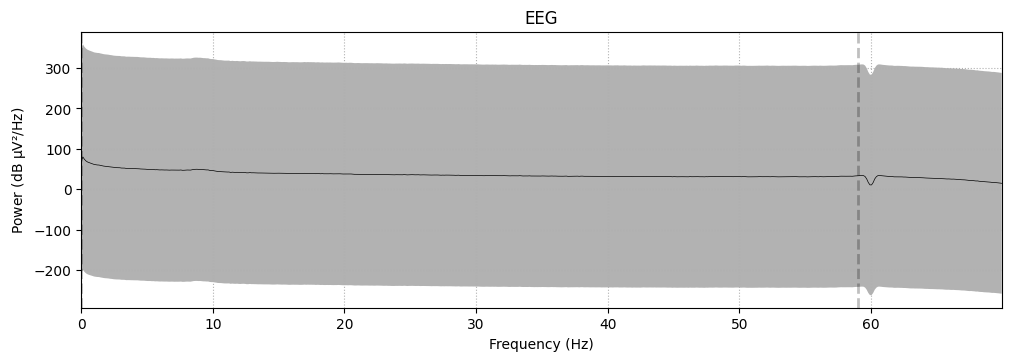

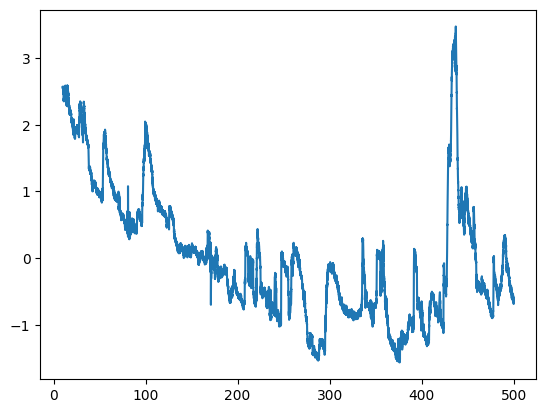

In [50]:
raw = all_ds.datasets[1].raw
fig = raw.compute_psd(fmax=70).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)
sampling_freq = raw.info["sfreq"]
print('sampling rate', sampling_freq)
start_stop_seconds = np.array([10, 500])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)
channel_index = 0
raw_selection = raw[channel_index, start_sample:stop_sample]
print(raw_selection)
x = raw_selection[1]
y = raw_selection[0].T
print(np.min(y),np.max(y))
plt.figure()
plt.plot(x, y)
plt.show()

### Set labels

In [51]:
target_name = 'age'
for ds in all_ds.datasets:
    ds.target_name = target_name

## Segment data windows <a class="anchor" id="third-bullet"></a>

In [52]:
window_len_s = 10
fs = all_ds.datasets[0].raw.info['sfreq']
print('sampling rate', fs)
window_len_samples = int(fs * window_len_s)
window_stride_samples = int(fs * window_len_s) # non-overlapping
windows_ds = create_fixed_length_windows(
    all_ds, start_offset_samples=0, stop_offset_samples=None,
    window_size_samples=window_len_samples,
    window_stride_samples=window_stride_samples, drop_last_window=True,
    preload=False)

sampling rate 250.0


In [ ]:
os.makedirs('data/hbn_preprocessed_windowed_scaled', exist_ok=True)
windows_ds.save('data/hbn_preprocessed_windowed_scaled', overwrite=True)

### Load segmented data windows <a class="anchor" id="fourth-bullet"></a>

In [4]:
window_len_s = 10

In [2]:
from braindecode.datautil import load_concat_dataset
windows_ds = load_concat_dataset(path='data/hbn_preprocessed_windowed_scaled', preload=False)

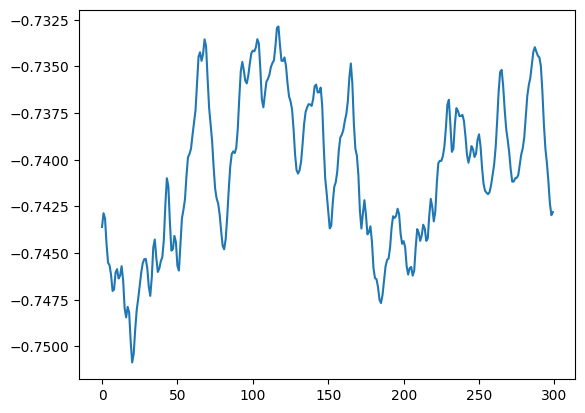

In [53]:
from matplotlib import pyplot as plt
sample_range = list(range(300))
plt.plot(sample_range, windows_ds[100][0][0,sample_range])
plt.show()

## Train-test split

In [13]:
random_state = 87
n_jobs = -1

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split

subjects = np.unique(windows_ds.description['subject'])
subj_train, subj_test = train_test_split(
    subjects, test_size=0.4, random_state=random_state)
subj_valid, subj_test = train_test_split(
    subj_test, test_size=0.5, random_state=random_state)

In [15]:
from libs.ssl_utils import RelativePositioningDataset

split_ids = {'train': subj_train, 'valid': subj_valid, 'test': subj_test}
splitted = dict()
for name, values in split_ids.items():
    splitted[name] = RelativePositioningDataset(
        [ds for ds in windows_ds.datasets
         if ds.description['subject'] in values])


In [16]:
print('train datasets', len(splitted['train'].datasets))
print('validation datasets', len(splitted['valid'].datasets))
print('test datasets', len(splitted['test'].datasets))
splitted['train'].get_metadata()

train datasets 162
validation datasets 54
test datasets 55


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:514: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(all_dfs)


,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,task,session,run,subject,sfreq,age,sex,ehq_total,p_factor,attention,internalizing,externalizing
0,0,0,2500,7.6979,RestingState,,,NDARZD415ZZ1,500,7.6979,M,93.38,-0.66,0.786,0.657,-0.398
1,1,2500,5000,7.6979,RestingState,,,NDARZD415ZZ1,500,7.6979,M,93.38,-0.66,0.786,0.657,-0.398
2,2,5000,7500,7.6979,RestingState,,,NDARZD415ZZ1,500,7.6979,M,93.38,-0.66,0.786,0.657,-0.398
3,3,7500,10000,7.6979,RestingState,,,NDARZD415ZZ1,500,7.6979,M,93.38,-0.66,0.786,0.657,-0.398
4,4,10000,12500,7.6979,RestingState,,,NDARZD415ZZ1,500,7.6979,M,93.38,-0.66,0.786,0.657,-0.398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,29,72500,75000,5.4358,RestingState,,,NDARTH433TE0,500,5.4358,M,100.05,0.94,-0.637,-0.349,1.055
30,30,75000,77500,5.4358,RestingState,,,NDARTH433TE0,500,5.4358,M,100.05,0.94,-0.637,-0.349,1.055
31,31,77500,80000,5.4358,RestingState,,,NDARTH433TE0,500,5.4358,M,100.05,0.94,-0.637,-0.349,1.055
32,32,80000,82500,5.4358,RestingState,,,NDARTH433TE0,500,5.4358,M,100.05,0.94,-0.637,-0.349,1.055


In [21]:
from braindecode.samplers import RelativePositioningSampler

sfreq = splitted['train'].datasets[0].raw.info['sfreq']
n_samples_per_dataset = 50
tau_pos, tau_neg = int(sfreq * 10), int(sfreq * 2 * 10)
n_examples_train = n_samples_per_dataset * len(splitted['train'].datasets)
n_examples_valid = n_samples_per_dataset * len(splitted['valid'].datasets)
n_examples_test = n_samples_per_dataset * len(splitted['test'].datasets)

train_sampler = RelativePositioningSampler(
    splitted['train'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_train, same_rec_neg=False, random_state=random_state)
valid_sampler = RelativePositioningSampler(
    splitted['valid'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_valid, same_rec_neg=False,
    random_state=random_state).presample()
test_sampler = RelativePositioningSampler(
    splitted['test'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_test, same_rec_neg=False,
    random_state=random_state).presample()

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:514: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(all_dfs)
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:514: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(all_dfs)
/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:514: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is depre

## Specify and train model with Torch Lightning

In [12]:
import lightning as L
import torch
from torch import nn
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet
from libs.evaluation import RankMe
# define the LightningModule
class LitSSL(L.LightningModule):
    def __init__(self, n_channels, sfreq, input_size_samples, window_len_s, emb_size, dropout=0.5):
        super().__init__()
        self.emb = self.create_embedding_layer(n_channels, sfreq, input_size_samples, window_len_s) #VGGSSL()
        self.pooling = nn.AdaptiveAvgPool2d(32)
        self.clf = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(1024, emb_size),
            nn.Dropout(dropout),
            nn.Linear(emb_size, 1)
        )
        self.rankme = RankMe()

    def create_embedding_layer(self, n_channels, sfreq, input_size_samples, window_len_s):
        return ShallowFBCSPNet(
            n_chans=n_channels,
            sfreq=sfreq,
            n_outputs=emb_size,
            # n_conv_chs=16,
            n_times=input_size_samples,
            input_window_seconds=window_len_s,
            # dropout=0,
            # apply_batch_norm=True,
        )

    def embed(self, x):
        z = self.clf[1](self.pooling(self.emb(x)).flatten(start_dim=1))
        return z

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        self.emb.train()
        X, y = batch
        x1, x2 = X[0], X[1]
        z1, z2 = self.emb(x1), self.emb(x2)
        z = self.pooling(torch.abs(z1 - z2)).flatten(start_dim=1)

        loss = nn.functional.binary_cross_entropy_with_logits(self.clf(z).flatten(), y)

        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        from sklearn import linear_model
        regr = linear_model.LinearRegression()
        X, Y, _ = batch
        z = self.embed(X)
        self.rankme.update(z)

        z = z.detach().cpu().numpy()
        Y = Y.detach().cpu().numpy()
        isnan = np.isnan(Y)
        embs = z[~isnan]
        labels = Y[~isnan]
        regr.fit(embs, labels)
        score = regr.score(embs, labels) 
        self.log('val_step_score', score)
        

    def test_step(self, batch, batch_idx):
        # this is the test loop
        X, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        test_loss = F.mse_loss(x_hat, x)
        self.log("test_loss", test_loss)

    def on_validation_epoch_end(self):
        # log epoch metric
        self.log('val_rankme', self.rankme.compute())

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

# Extract number of channels and time steps from dataset
n_channels, input_size_samples = windows_ds[0][0].shape
emb_size = 100
classes = list(range(5))

model = LitSSL(n_channels, sfreq, input_size_samples, window_len_s, emb_size)

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [13]:
train_loader = DataLoader(splitted['train'], sampler=train_sampler, batch_size=128, num_workers=4)
splitted['valid'].return_pair = False
val_loader = DataLoader(splitted['valid'], batch_size=128, num_workers=4)
# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
trainer = L.Trainer(max_epochs=1, accelerator='gpu')
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader) #, ckpt_path="lightning_logs/version_10/checkpoints/epoch=199-step=20000.ckpt")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | emb     | ShallowFBCSPNet   | 327 K  | eval 
1 | pooling | AdaptiveAvgPool2d | 0      | train
2 | clf     | Sequential        | 102 K  | train
3 | rankme  | RankMe            | 0      | train
------------------------------------------------------
430 K     Trainable params
0         Non-trainable params
430 K     Total params
1.721     Total estimated model params size (MB)
11        Modules in train mode
11        Modules in eval mode


Epoch 0: 100%|██████████| 64/64 [00:14<00:00,  4.45it/s, v_num=15]         

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 64/64 [00:14<00:00,  4.44it/s, v_num=15]


In [22]:
train_loader = DataLoader(splitted['train'], sampler=train_sampler, batch_size=128, num_workers=4)
print(len(splitted['train']))
for i in train_loader:
    X, Y = i
    print(X[0].shape)
    break

6372


torch.Size([128, 129, 2500])


In [46]:
i = next(iter(train_loader))
i[0][0][0].shape

torch.Size([129, 2500])

In [14]:
# Load the TensorBoard notebook extension
%load_ext tensorboard